In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [63]:
def parse(file):
    with open(file,'r') as readFile:                                                                                        #convert lines in file to list
        file = readFile.readlines()

    stop = False
    thermData = []
    thermTime = []
    tCoupData = []
    tCoupTime = []
    countLines = 0
    for i in file:
        if 'DATAQ:' in i and not stop:
            tCoupData.append(float(i.split()[4].strip(',')))
            try:
                    tCoupTime.append(float(file[countLines-1].split()[0].strip('()'))/1000)
                    # totalTime.append(float(file[countLines-1].split()[0].strip('()'))/1000)
            except:
                if file[countLines+1].split()[0] != 'DATAQ:':
                    tCoupTime.append(float(file[countLines+1].split()[0].strip('()'))/1000)
                else:
                    try:
                        tCoupTime.append(float(file[countLines-2].split()[0].strip('()'))/1000)
                    except:
                        try:
                            tCoupTime.append(float(file[countLines+2].split()[0].strip('()'))/1000)
                        except:
                            print(file[countLines])
                            tCoupTime.append(float(file[countLines-3].split()[0].strip('()'))/1000)
        elif 'modeled' in i and not stop:
            thermData.append(float(i.split()[4].strip(',')))
            thermTime.append(float(i.split()[0].strip('()'))/1000)
            if float(i.split()[4].strip(',')) > 114:
                stop = True
        
        countLines += 1
    thermTime = np.array(thermTime)-thermTime[0]
    tCoupTime = np.array(tCoupTime)-tCoupTime[0]
    return (thermTime,thermData),(tCoupTime,tCoupData)
def r2(y,fit):
    y = np.array(y)
    fit = np.array(fit)
    st = sum((y-np.average(y))**2)
    sr = sum((y-fit)**2)
    r2 = 1-sr/st
    return r2

def test(x,a,b,c):
    return a*np.log(x+c)+b

In [64]:
file = 'data/JW_mod4_tcInMiddle_1.txt'
file2 = 'data/JW_mod4_tcInMiddleWithCupFail_2.txt'
file3 = 'data/JW_mod4_tcInSide_3.txt'

x1,y1 = parse(file)[0]
x2,y2 = parse(file)[1]

x3,y3 = parse(file2)[0]
x4,y4 = parse(file2)[1]

x5,y5 = parse(file3)[0]
x6,y6 = parse(file3)[1]

0.9228141564075593
2.7199864829432587


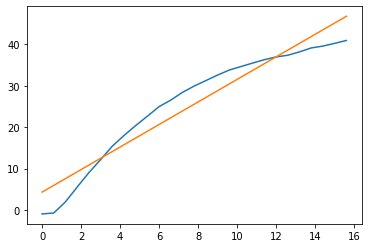

In [66]:
# xTherm,yTherm = interp1d(x1,y1)

newTherm = interp1d(x1,y1)
newCoup = interp1d(x2,y2)

diff = newTherm(x2) - newCoup(x2)
a,b = np.polyfit(x2,diff,1)

plt.plot(x2,diff)
plt.plot(x2,a*x2+b)
print(r2(diff,a*x2+b))
;

print(a)